# Springboard Data Science Track Capstone Project 1
### Histopathologic Cancer Detection
### by Morgan Fry
### Data Exploration notebook


#### We are examining images of slides of lymph tissue samples treated with contrast in order to detect cancer cells. This notebook will look at these images as data and see what we can tell

In [1]:
#includes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
%matplotlib inline

from matplotlib.image import imread
import cv2    

from sklearn.utils import shuffle
import pickle
import sys
import seaborn as sns

In [2]:
#load data saved in data wrangling notebook
y=pickle.load(open("saved/y.p","rb"))
X=pickle.load(open("saved/X.p","rb"))
X_v=pickle.load(open("saved/X_vect.p","rb"))
#X_gray=pickle.load(open("saved/X_gray.p","rb"))
#X_gray_vect=pickle.load(open("saved/X_gra_vect.p","rb"))

##### Let's look at a few of the samples, in color and in grayscale

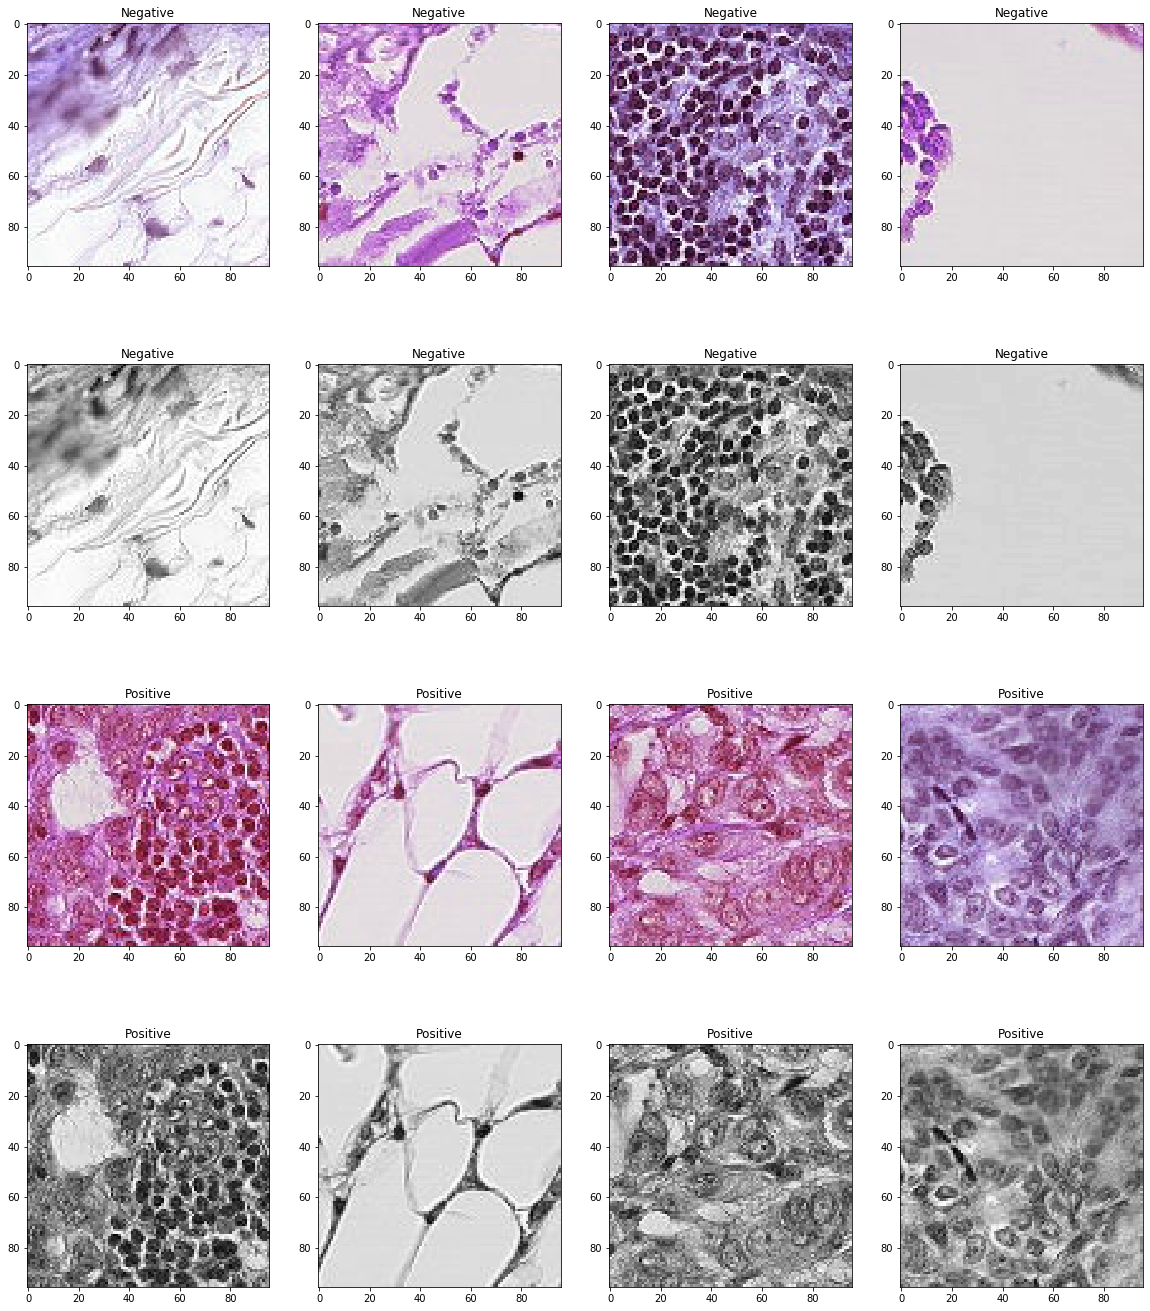

In [4]:
#select 4 negatives and 4 positives at random
shuffled_y=shuffle(y)

fig,ax = plt.subplots(4,4, figsize=(20,24))

#4 negatives
for i, idx in enumerate(shuffled_y[shuffled_y['label'] == 0]['id'][:4]):
    ax[0,i].imshow(X.get(idx))
    ax[0,i].set_title('Negative')
    ax[1,i].imshow(cv2.cvtColor(X.get(idx), cv2.COLOR_BGR2GRAY), cmap='gray')
    ax[1,i].set_title('Negative')        

#4 positives
for i, idx in enumerate(shuffled_y[shuffled_y['label'] == 1]['id'][:4]):
    ax[2,i].imshow(X.get(idx))
    ax[2,i].set_title('Positive')
    ax[3,i].imshow(cv2.cvtColor(X.get(idx), cv2.COLOR_BGR2GRAY), cmap='gray')
    ax[3,i].set_title('Positive') 


##### To begin looking for trends in the data, first we'll split into positive and negative groups in advance of plotting some features


In [7]:
#first sort the positive and negative slides into lists. 
X_p,X_n=[],[]
for idx,row in y.iterrows():
    if row.label==1:
        X_p.append(X.get(row.id)) 
        #X_p_g.append(X_gray.get(row.id))
    else:
        X_n.append(X.get(row.id))
        #X_n_g.append(X_gray.get(row.id))
       

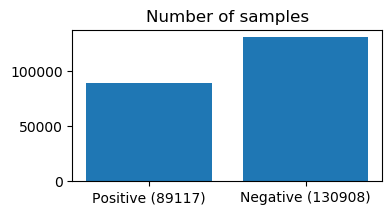

In [13]:
#samples=[len(X_pos),len(X_neg)]

fig = plt.figure(figsize=(4, 2),dpi=100)
plt.bar([1,0], [len(X_n),len(X_p)])
plt.xticks([1,0],["Negative ({})".format(len(X_n)),"Positive ({})".format(len(X_p))])
plt.title("Number of samples")
plt.show()

##### First of all, we can notice that the training data contains about 60% negative and 40% positive samples.


The dataset is made up of images, so a few ways of exploring the data come to mind:
* intensity of each of the color channels
* aggregations of the channels


In [9]:
#split the images by channel

bp,gp,rp,bn,gn,rn=[],[],[],[],[],[]
for each in X_p:
    bp,gp,rp=cv2.split(each)
for each in X_n:
    bn,gn,rn=cv2.split(each)

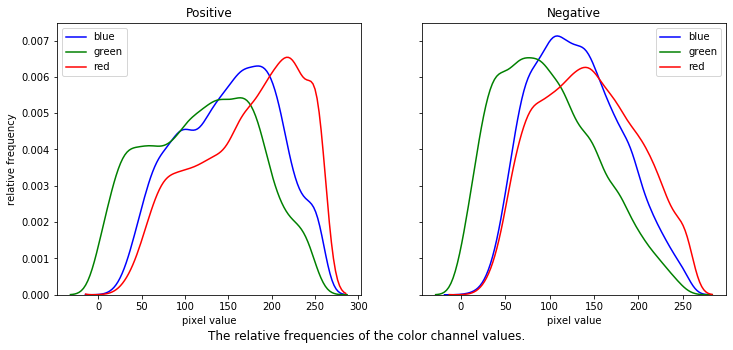

In [10]:
fig,axs = plt.subplots(1,2,sharey=True,figsize=(12,5))

sns.distplot(bp,hist=False,color='blue',label='blue',ax=axs[0]).set_title('Positive')
sns.distplot(gp,hist=False,color='green',label='green',ax=axs[0]).set_xlabel('pixel value')
sns.distplot(rp,hist=False,color='red',label='red',ax=axs[0]).set_ylabel('relative frequency')
sns.distplot(bn,hist=False,color='blue',label='blue',ax=axs[1]).set_title('Negative')
sns.distplot(gn,hist=False,color='green',label='green',ax=axs[1]).set_xlabel('pixel value')
sns.distplot(rn,hist=False,color='red',label='red',ax=axs[1])

plt.figtext(.3,0,'The relative frequencies of the color channel values.',fontsize='large')
plt.show()

There appears to be some differences between the positive and negative sets, so let's compare the individual color channels individually to see if anything sticks out.

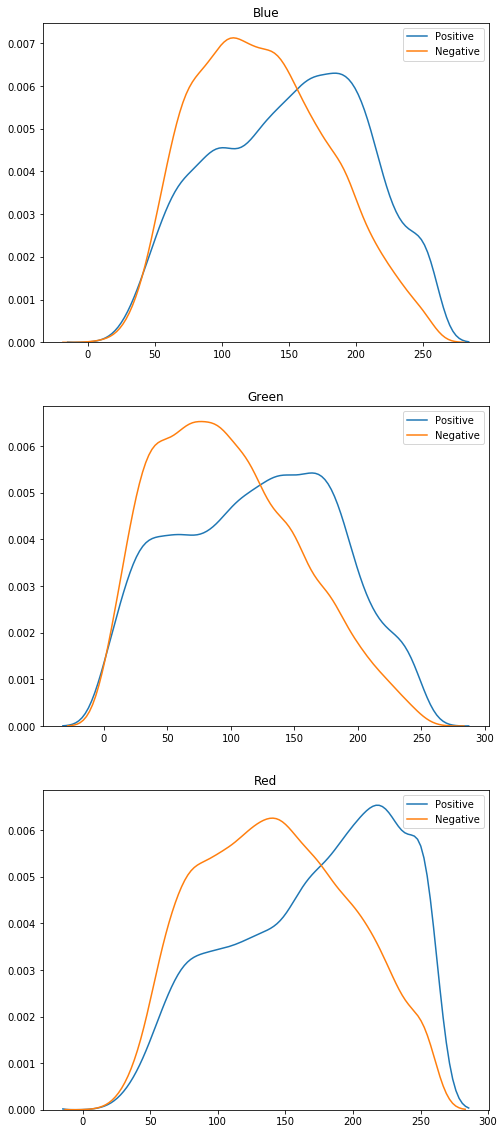

In [14]:
fig,axs = plt.subplots(3,1,figsize=(8,20))

sns.distplot(bp,hist=False,label='Positive',ax=axs[0]).set_title('Blue')
sns.distplot(bn,hist=False,label='Negative',ax=axs[0])
sns.distplot(gp,hist=False,label='Positive',ax=axs[1]).set_title('Green')
sns.distplot(gn,hist=False,label='Negative',ax=axs[1])
sns.distplot(rp,hist=False,label='Positive',ax=axs[2]).set_title('Red')
sns.distplot(rn,hist=False,label='Negative',ax=axs[2])
#sns.distplot(X_pg,hist=False,label='Positive',ax=axs[3]).set_title('Grayscale')
#sns.distplot(X_ng,hist=False,label='Negative',ax=axs[3])
plt.show()

#### We can begin to see a difference in the distribution of color between positive and negative samples. Among the Positive group we see:
* All channels seem shifted to the right, indicating more color in the positive samples.

#### Next we will examine the results of some aggregation to see if there is anything we can learn there.

In [15]:
#create some aggregates of the data
X_p_v=[a.flatten() for a in X_p]
X_n_v=[a.flatten() for a in X_n]
X_p_mean=[np.mean(each) for each in X_p_v]
X_n_mean=[np.mean(each) for each in X_n_v]
X_p_med=[np.median(each) for each in X_p_v]
X_n_med=[np.median(each) for each in X_n_v]

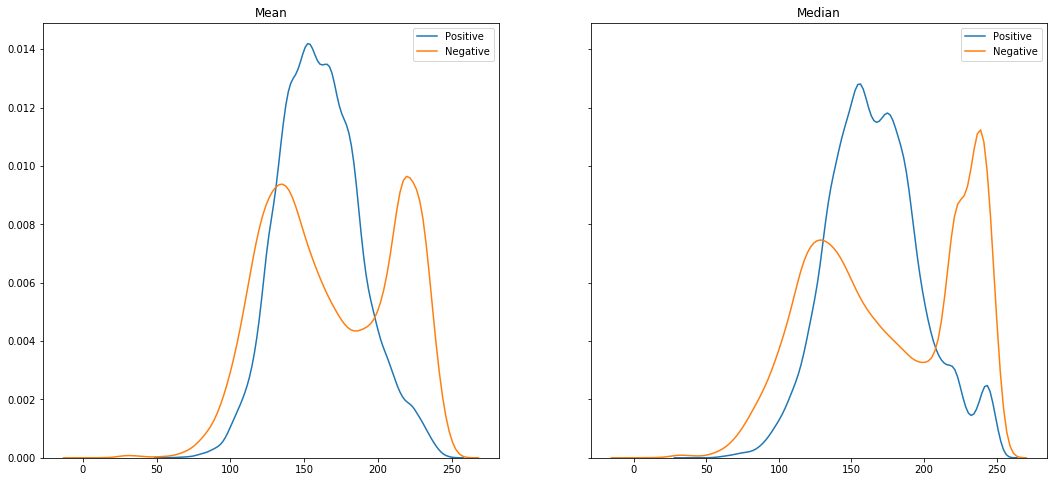

In [16]:
fig,axs = plt.subplots(1,2, sharey=True, figsize=(18,8))

sns.distplot(X_p_mean,hist=False,label='Positive',ax=axs[0]).set_title('Mean')
sns.distplot(X_n_mean,hist=False,label='Negative',ax=axs[0])
sns.distplot(X_p_med,hist=False,label='Positive',ax=axs[1]).set_title('Median')
sns.distplot(X_n_med,hist=False,label='Negative',ax=axs[1])

plt.show()

###### There is a clear difference in the distribution of the mean values of the positive and negative sets, with the negative having a bimodal distribution. The plot of the medians looks similar to the means, we can conclude from this that the data don't have a lot of outliers.

Given the obvious difference between positive and negative here, it may be informative to see if ano one channel is particularly responsible. So let's look at similar aggregations for the individual color channels 

In [19]:
bp_mean=[np.mean(np.ravel(a)) for a in bp]
bn_mean=[np.mean(np.ravel(a)) for a in bn]
gp_mean=[np.mean(np.ravel(a)) for a in gp]
gn_mean=[np.mean(np.ravel(a)) for a in gn]
rp_mean=[np.mean(np.ravel(a)) for a in rp]
rn_mean=[np.mean(np.ravel(a)) for a in rn]

In [20]:
bp_med=[np.median(np.ravel(a)) for a in bp]
bn_med=[np.median(np.ravel(a)) for a in bn]
gp_med=[np.median(np.ravel(a)) for a in gp]
gn_med=[np.median(np.ravel(a)) for a in gn]
rp_med=[np.median(np.ravel(a)) for a in rp]
rn_med=[np.median(np.ravel(a)) for a in rn]

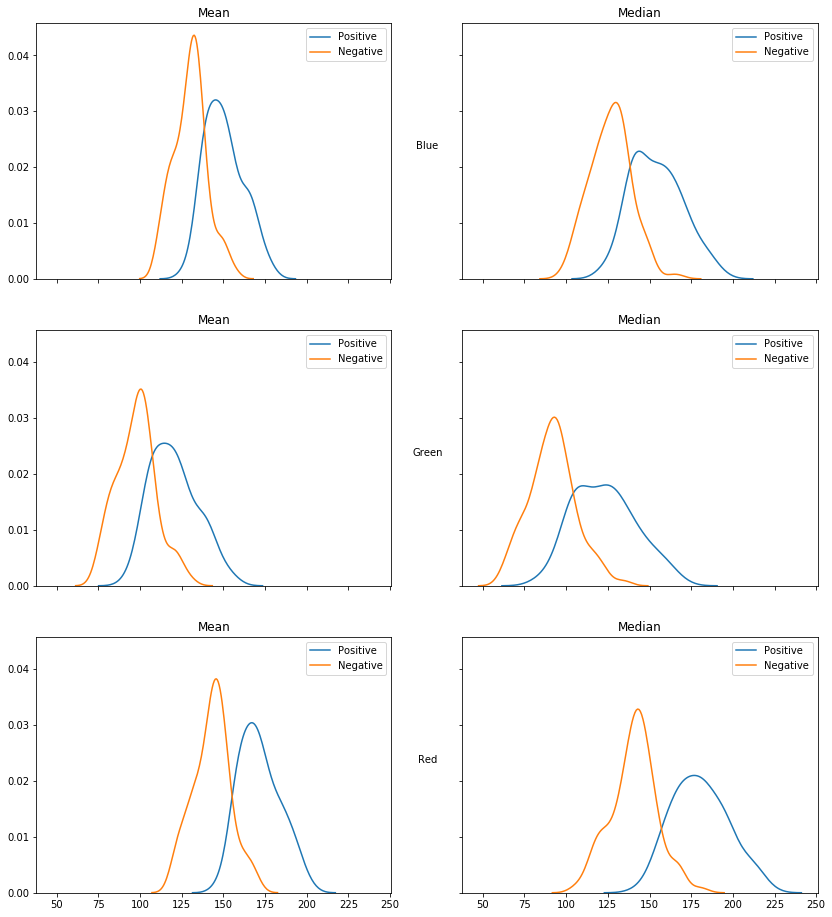

In [21]:
fig,axs = plt.subplots(3,2, sharey=True, sharex=True,figsize=(14,16))

sns.distplot(gp_mean,hist=False,label='Positive',ax=axs[1,0]).set_title('Mean')
sns.distplot(gn_mean,hist=False,label='Negative',ax=axs[1,0])
sns.distplot(gp_med,hist=False,label='Positive',ax=axs[1,1]).set_title('Median')
sns.distplot(gn_med,hist=False,label='Negative',ax=axs[1,1]).set_ylabel("Green",rotation='horizontal',labelpad=35)
sns.distplot(rp_mean,hist=False,label='Positive',ax=axs[2,0]).set_title('Mean')
sns.distplot(rn_mean,hist=False,label='Negative',ax=axs[2,0])
sns.distplot(rp_med,hist=False,label='Positive',ax=axs[2,1]).set_title('Median')
sns.distplot(rn_med,hist=False,label='Negative',ax=axs[2,1]).set_ylabel("Red",rotation='horizontal',labelpad=35)
sns.distplot(bp_mean,hist=False,label='Positive',ax=axs[0,0]).set_title('Mean')
sns.distplot(bn_mean,hist=False,label='Negative',ax=axs[0,0])
sns.distplot(bp_med,hist=False,label='Positive',ax=axs[0,1]).set_title('Median')
sns.distplot(bn_med,hist=False,label='Negative',ax=axs[0,1]).set_ylabel("Blue",rotation='horizontal',labelpad=35)

plt.show()

There is a pretty significant difference in all channels. In the positive samples, vallues are all greater and slightly more evenly distributed.

#### Truncating the data
This dataset comes from the PatchCamelyon set with duplicates removed, and according to the provider ov the data a positive  sample is defined as the center 32x32 pixel region containing at least 1 pixel of tumor tissue. As such, it may be interesting to see if the data from just this region tellsa different or clearer story than the data as a whole.

################## deprecated its all lists now##############3
#first task is to crop the images.
#function to crop to the middle of these images
#returns dictionary
def crop_img(Xl):
    X_t={}
    for k,v in Xl.items():
        X_t[k]=v[32:63,32:63]
    return(X_t)

In [46]:
X_p_c=[a[31:63,31:63] for a in X_p]
X_n_c=[a[31:63,31:63] for a in X_n]
bp_c=[a[31:63]for a in bp]
bn_c=[a[31:63]for a in bn]
gp_c=[a[31:63]for a in gp]
gn_c=[a[31:63]for a in gn]
rp_c=[a[31:63]for a in rp]
rn_c=[a[31:63]for a in rn]


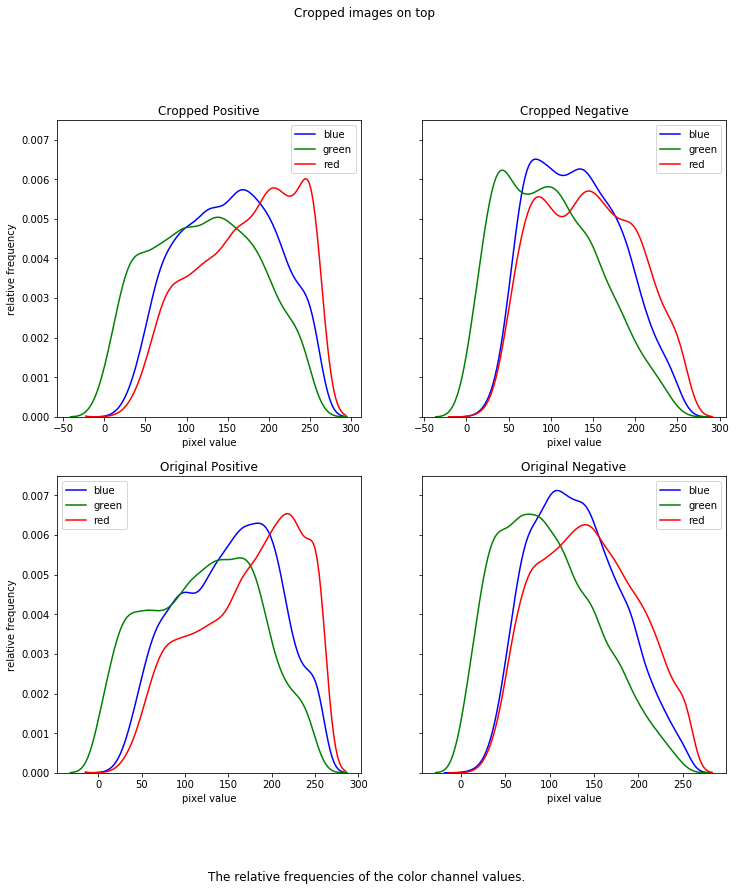

In [47]:
fig,axs = plt.subplots(2,2,sharey=True,figsize=(12,12))

sns.distplot(bp_c,hist=False,color='blue',label='blue',ax=axs[0,0]).set_title('Cropped Positive')
sns.distplot(gp_c,hist=False,color='green',label='green',ax=axs[0,0]).set_xlabel('pixel value')
sns.distplot(rp_c,hist=False,color='red',label='red',ax=axs[0,0]).set_ylabel('relative frequency')
sns.distplot(bn_c,hist=False,color='blue',label='blue',ax=axs[0,1]).set_title('Cropped Negative')
sns.distplot(gn_c,hist=False,color='green',label='green',ax=axs[0,1]).set_xlabel('pixel value')
sns.distplot(rn_c,hist=False,color='red',label='red',ax=axs[0,1])

sns.distplot(bp,hist=False,color='blue',label='blue',ax=axs[1,0]).set_title('Original Positive')
sns.distplot(gp,hist=False,color='green',label='green',ax=axs[1,0]).set_xlabel('pixel value')
sns.distplot(rp,hist=False,color='red',label='red',ax=axs[1,0]).set_ylabel('relative frequency')
sns.distplot(bn,hist=False,color='blue',label='blue',ax=axs[1,1]).set_title('Original Negative')
sns.distplot(gn,hist=False,color='green',label='green',ax=axs[1,1]).set_xlabel('pixel value')
sns.distplot(rn,hist=False,color='red',label='red',ax=axs[1,1])

plt.figtext(.3,0,'The relative frequencies of the color channel values.',fontsize='large')
plt.figtext(.4,1,'Cropped images on top',fontsize='large')
plt.show()

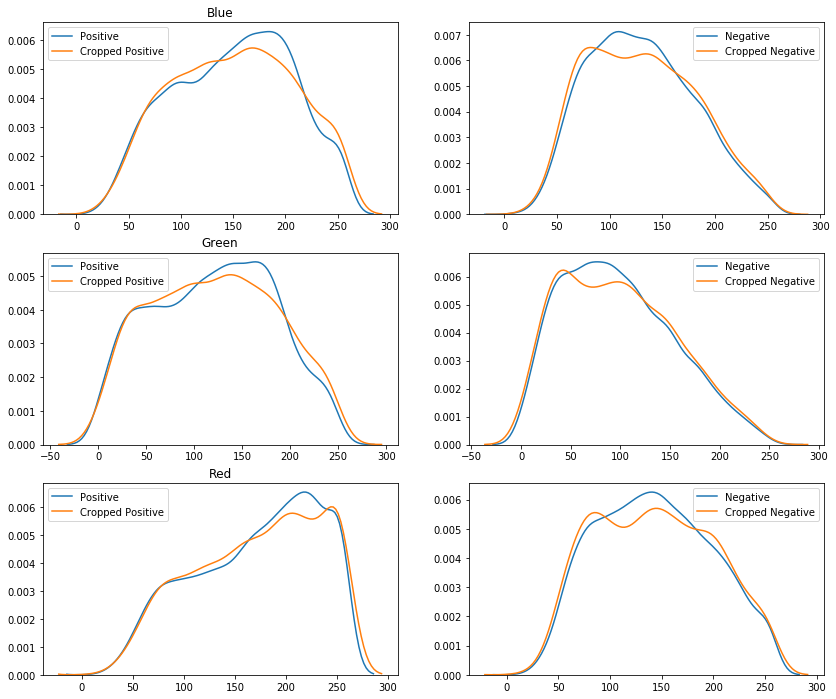

In [48]:
#individual channels
fig,axs = plt.subplots(3,2,figsize=(14,12))

sns.distplot(bp,hist=False,label='Positive',ax=axs[0,0]).set_title('Blue')
sns.distplot(bn,hist=False,label='Negative',ax=axs[0,1])
sns.distplot(gp,hist=False,label='Positive',ax=axs[1,0]).set_title('Green')
sns.distplot(gn,hist=False,label='Negative',ax=axs[1,1])
sns.distplot(rp,hist=False,label='Positive',ax=axs[2,0]).set_title('Red')
sns.distplot(rn,hist=False,label='Negative',ax=axs[2,1])

sns.distplot(bp_c,hist=False,label='Cropped Positive',ax=axs[0,0])
sns.distplot(bn_c,hist=False,label='Cropped Negative',ax=axs[0,1])
sns.distplot(gp_c,hist=False,label='Cropped Positive',ax=axs[1,0])
sns.distplot(gn_c,hist=False,label='Cropped Negative',ax=axs[1,1])
sns.distplot(rp_c,hist=False,label='Cropped Positive',ax=axs[2,0])
sns.distplot(rn_c,hist=False,label='Cropped Negative',ax=axs[2,1])


plt.show()

In [50]:
#create some aggregates of the data
X_p_c_v=[a.flatten() for a in X_p_c]
X_n_c_v=[a.flatten() for a in X_n_c]
X_p_c_mean=[np.mean(each) for each in X_p_c_v]
X_n_c_mean=[np.mean(each) for each in X_n_c_v]
X_p_c_med=[np.median(each) for each in X_p_c_v]
X_n_c_med=[np.median(each) for each in X_n_c_v]

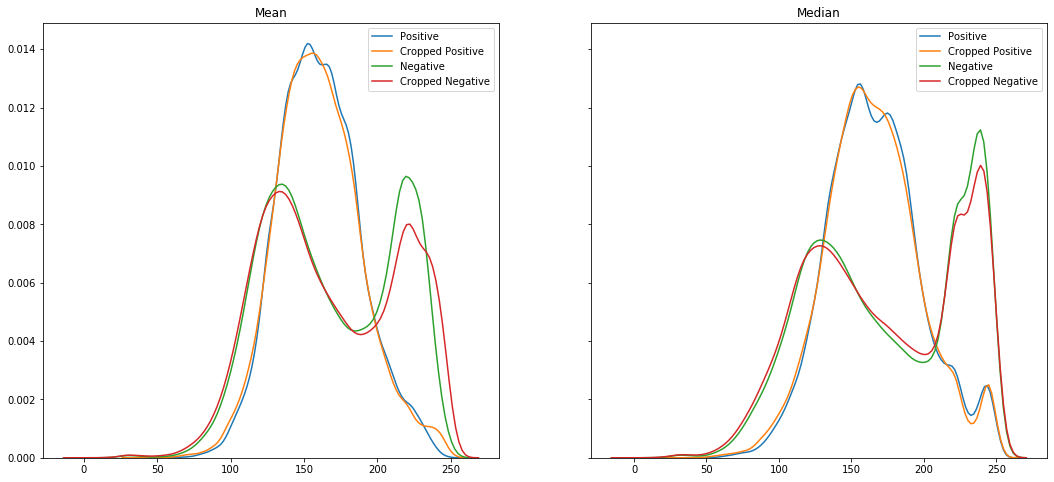

In [55]:
fig,axs = plt.subplots(1,2, sharey=True, figsize=(18,8))

sns.distplot(X_p_mean,hist=False,label='Positive',ax=axs[0]).set_title('Mean')
sns.distplot(X_p_c_mean,hist=False,label='Cropped Positive',ax=axs[0])
sns.distplot(X_n_mean,hist=False,label='Negative',ax=axs[0])
sns.distplot(X_n_c_mean,hist=False,label='Cropped Negative',ax=axs[0])

sns.distplot(X_p_med,hist=False,label='Positive',ax=axs[1]).set_title('Median')
sns.distplot(X_p_c_med,hist=False,label='Cropped Positive',ax=axs[1])
sns.distplot(X_n_med,hist=False,label='Negative',ax=axs[1])
sns.distplot(X_n_c_med,hist=False,label='Cropped Negative',ax=axs[1])


plt.show()

Aggregate values so far don't show much consistent difference between using the entire images and the cener square.

In [56]:
bp_c_mean=[np.mean(np.ravel(a)) for a in bp_c]
bn_c_mean=[np.mean(np.ravel(a)) for a in bn_c]
gp_c_mean=[np.mean(np.ravel(a)) for a in gp_c]
gn_c_mean=[np.mean(np.ravel(a)) for a in gn_c]
rp_c_mean=[np.mean(np.ravel(a)) for a in rp_c]
rn_c_mean=[np.mean(np.ravel(a)) for a in rn_c]

In [57]:
bp_c_med=[np.median(np.ravel(a)) for a in bp_c]
bn_c_med=[np.median(np.ravel(a)) for a in bn_c]
gp_c_med=[np.median(np.ravel(a)) for a in gp_c]
gn_c_med=[np.median(np.ravel(a)) for a in gn_c]
rp_c_med=[np.median(np.ravel(a)) for a in rp_c]
rn_c_med=[np.median(np.ravel(a)) for a in rn_c]

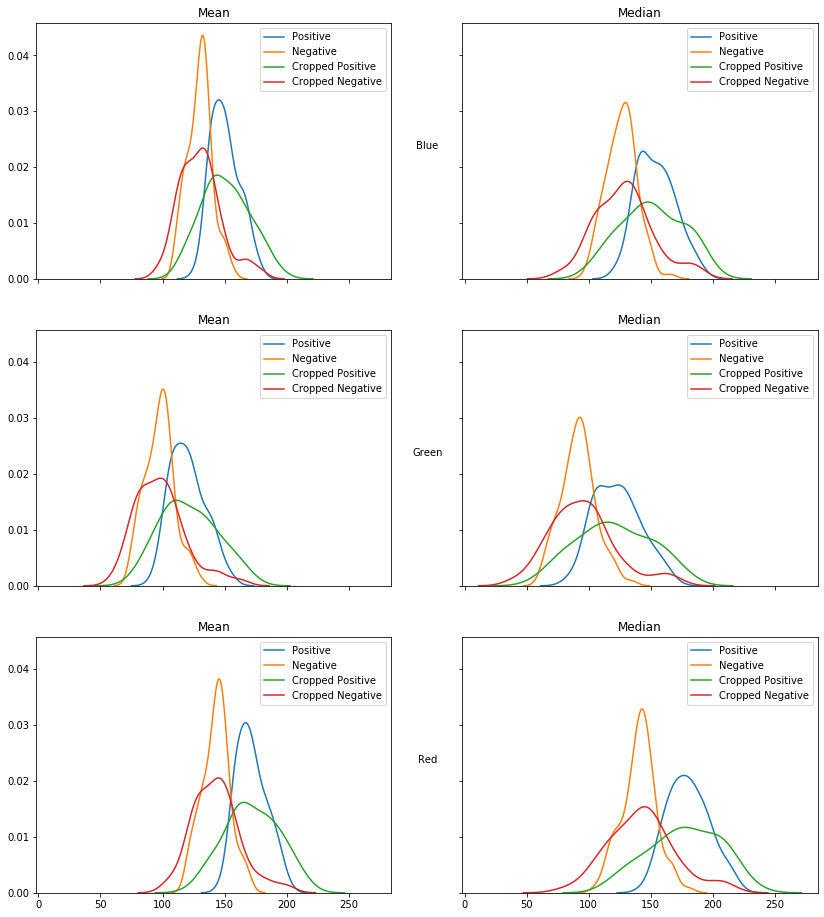

In [59]:
fig,axs = plt.subplots(3,2, sharey=True, sharex=True,figsize=(14,16))

sns.distplot(gp_mean,hist=False,label='Positive',ax=axs[1,0]).set_title('Mean')
sns.distplot(gn_mean,hist=False,label='Negative',ax=axs[1,0])
sns.distplot(gp_med,hist=False,label='Positive',ax=axs[1,1]).set_title('Median')
sns.distplot(gn_med,hist=False,label='Negative',ax=axs[1,1]).set_ylabel("Green",rotation='horizontal',labelpad=35)
sns.distplot(rp_mean,hist=False,label='Positive',ax=axs[2,0]).set_title('Mean')
sns.distplot(rn_mean,hist=False,label='Negative',ax=axs[2,0])
sns.distplot(rp_med,hist=False,label='Positive',ax=axs[2,1]).set_title('Median')
sns.distplot(rn_med,hist=False,label='Negative',ax=axs[2,1]).set_ylabel("Red",rotation='horizontal',labelpad=35)
sns.distplot(bp_mean,hist=False,label='Positive',ax=axs[0,0]).set_title('Mean')
sns.distplot(bn_mean,hist=False,label='Negative',ax=axs[0,0])
sns.distplot(bp_med,hist=False,label='Positive',ax=axs[0,1]).set_title('Median')
sns.distplot(bn_med,hist=False,label='Negative',ax=axs[0,1]).set_ylabel("Blue",rotation='horizontal',labelpad=35)

sns.distplot(gp_c_mean,hist=False,label='Cropped Positive',ax=axs[1,0]).set_title('Mean')
sns.distplot(gn_c_mean,hist=False,label='Cropped Negative',ax=axs[1,0])
sns.distplot(gp_c_med,hist=False,label='Cropped Positive',ax=axs[1,1]).set_title('Median')
sns.distplot(gn_c_med,hist=False,label='Cropped Negative',ax=axs[1,1]).set_ylabel("Green",rotation='horizontal',labelpad=35)
sns.distplot(rp_c_mean,hist=False,label='Cropped Positive',ax=axs[2,0]).set_title('Mean')
sns.distplot(rn_c_mean,hist=False,label='Cropped Negative',ax=axs[2,0])
sns.distplot(rp_c_med,hist=False,label='Cropped Positive',ax=axs[2,1]).set_title('Median')
sns.distplot(rn_c_med,hist=False,label='Cropped Negative',ax=axs[2,1]).set_ylabel("Red",rotation='horizontal',labelpad=35)
sns.distplot(bp_c_mean,hist=False,label='Cropped Positive',ax=axs[0,0]).set_title('Mean')
sns.distplot(bn_c_mean,hist=False,label='Cropped Negative',ax=axs[0,0])
sns.distplot(bp_c_med,hist=False,label='Cropped Positive',ax=axs[0,1]).set_title('Median')
sns.distplot(bn_c_med,hist=False,label='Cropped Negative',ax=axs[0,1]).set_ylabel("Blue",rotation='horizontal',labelpad=35)

plt.show()

The aggregate values of the individual channels in the cropped images are a little less distinct than in the full images.